## ExptModel_class.py

This class handles evaluation of the user-defined model function.

### Methods

#### `ExptModel.model_config(self, settings, parameters, constants)`

This method prepares arrays of all possible setting combinations and arrays of all possible parameter combinations.  These arrays are used in evaluating the model function in order to determine useful measurement settings and to update the probability distribution function with new measurement data. 
- `settings` is a tuple of numpy arrays, an array of allowed values for each experimental setting. Settings are properties of the measuring equipment.
- `parameters` is a tuple of numpy arrays, an array for each parameter.  Parameters are properties of the thing that's getting measured.  The OptBayesExpt methods will refine the probability distribution over the parameter values given in these arrays.
- `constants` is a tuple of floats that serve as constants in the model.

  
#### `ExptModel.model_function(self, sets, pars, cons)`

A placeholder for the user-defined model function.  This function will be called in two different modes, either evaluating the model at all possible settings or evaluating at all possible parameters.  Using the flexibility of numpy arrays, a single model_function can handle both modes
* _setting mode_:  Used in determining useful measurement settings, the model_function is evaluated with
  - `sets` a tuple of arrays (possibly multidimensional) covering all possible settings combinations
  - `pars` a tuple of floats representing a single set of parameter values
  - `cons` a tuple of model constants
* _learning mode_: Used in incorporating new measurement values into the parameter probability distribution
  - `sets` a tuple of floats representing a single set of setting values
  - `pars` a tuple of arrays (possibly multidimensional) covering all possible parameter combinations
  - `cons` a tuple of model constants
  
#### `eval_over_all_parameters(self, onesettingset)`

A wrapper that calls the `model_function` in _learning mode_, evaluating over parameters 
   - `onesettingset` a tuple of floats representing a single set of settings.
   
#### `eval_over_all_settings(self, oneparamset)`

A wrapper that calls the `model_function` in _setting mode_, evaluating over all settings  
   - `oneparamset` a tuple of floats representing a single set of parameters.

### Self test / Example

allsettings.shape = (101,)
allparams.shape = (41, 50)


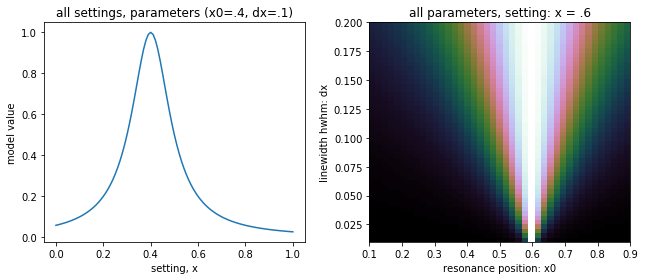

In [7]:
from ExptModel_class import ExptModel

def self_test():
    """
    Example Lorentzian Experimental model

    Pretend we have a spectrometer with a knob that goes from 0 to 1 in 100 steps.
    We're measuring something that we think is going to produce a Lorentzian peak.
    """
    ## define the space of settings and parameters

    # settings
    # these are settings for the spectrometer.
    # The spectrometer has a control knob that goes from 0 to 1 in 100 steps.
    xvals = np.linspace(0, 1, 101)
    # Our spectrometer could have more than one setting in general, so we pack the settings in a tuple,
    # even though it's not really necessary in this example.
    settings = (xvals,)

    # parameters
    # Model parameters that you would allow to vary in a fit to measured data.
    # in this case, a peak center (x0) and a lhwhm ine width (dx) are values I'd like to determine.
    # These parameters could take on any real value in the physical world, but here in the computer,
    # the possible values are discrete
    # peak center.  41 possible values, 0.02 precision
    x0vals = np.linspace(.1, .9, 41)
    # width.  50 possible values 0.004 precision
    dwvals = np.linspace(.01, .2, 50)
    # pack the parameters in a tuple
    parameters = (x0vals, dwvals)

    # constants
    # Model parameters that you would decide to keep constant in a fit to measured data.
    # in this case, I "know" that my peak height is 1.0.
    A = 1.0
    # Again, only one constant, but we pack it in a tuple anyways to show the general form
    constants = (A, )

    # make a model that predicts the output of our spectrometer given settings, parametes, constants
    class LorentzModel(ExptModel):
        """
        A model specifically for Lorentzian peaks, inheriting from the ExptModel class.
        """

        def __init__(self):
            ExptModel.__init__(self)

        # The ExptModel class focuses on creating different ways to evaluate the model, but "passes"
        # on defining the model function.  Here's where we make that definition
        def model_function(self, settuple, partuple, contuple):
            """
            This is a tiny piece of code, but it's a big deal from the user perspective because it's the part
            that users will need to adapt to different models. Here, the programmer defines the model
            and how the settings, parameters and constants are interpreted.
            :param settings:   tuple of instrument settings
            :param parameters: tuple of model parameters, unknowns treated as discrete variables
            :param constants:  tuple of model constants.
            :return:
            """

            # unpack our input tuples

            # experimental settings
            x = settuple[0]
            # model parameters
            x0 = partuple[0]
            dx = partuple[1]
            # constants
            A = contuple[0]

            # and now our model for the expected spectrometer output
            return A / (1 + (x - x0) ** 2 / dx ** 2)
            # OK, this is just a one-liner, but the model could be much more complex.

    # Settings, Parameters, Constants all defined
    # Model is defined
    # Next is to start calculating

    # create a model instance
    lmodel = LorentzModel()
    lmodel.model_config(settings, parameters, constants)
    print('allsettings.shape = {}'.format(lmodel.allsettings[0].shape))
    print('allparams.shape = {}'.format(lmodel.allparams[0].shape))
    # calculate for all settings (like an experimental sweep)
    oneparameter = (.4, .1)
    ytrace = lmodel.eval_over_all_settings(oneparameter)

    # calculate for all parameters ( for likelihood calc )
    onesetting = (.6,)
    pspace = lmodel.eval_over_all_parameters(onesetting)

    # Calculations done.

    #
    # plot the results
    #
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(9,4))

    # all settings plot
    plt.subplot(121)
    plt.plot(xvals, ytrace)
    plt.xlabel('setting, x')
    plt.ylabel('model value')
    plt.title("all settings, parameters (x0=.4, dx=.1)")

    # all parameters image
    plt.subplot(122)
    extent = [parameters[0].min(), parameters[0].max(), parameters[1].min(), parameters[1].max()]
    plt.imshow(pspace.T, cmap='cubehelix', origin = 'bottom', extent=extent, aspect = 'auto')
    plt.ylabel('linewidth hwhm: dx')
    plt.xlabel('resonance position: x0')
    plt.title('all parameters, setting: x = .6')
    plt.tight_layout()

    plt.show()

if __name__ == '__main__':
    self_test()
